# Processing

In [ ]:
!pip install -Uq pip setuptools wheel
!pip install -Uq spacy
!python -m spacy download es_core_news_lg
!python -m spacy download es_dep_news_trf
!pip install -q fsspec

     |████████████████████████████████| 1.6MB 3.2MB/s 
     |████████████████████████████████| 12.8 MB 86 kB/s 
     |████████████████████████████████| 9.1 MB 45.0 MB/s 
     |████████████████████████████████| 456 kB 37.4 MB/s 
     |████████████████████████████████| 42 kB 819 kB/s 
     |████████████████████████████████| 1.1 MB 39.6 MB/s 
     |████████████████████████████████| 113 kB 46.9 MB/s 
2021-06-09 02:03:44.480670: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 569.7 MB 23 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
2021-06-09 02:04:36.243824: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 409.9 MB 22 kB/s 
     |████████████████████████████████| 2.1 MB 3.9 MB/s 
     |███████████████████████████

In [ ]:
import json
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/Shareddrives/Data Mining 2021/Project - DataMining/News/'
#urls_path = root_path + 'urls.json'
#crawled_path = root_path + 'crawled.json'

semana_urls_path = root_path + 'data/semana/urls.json'
semana_crawled_path = root_path + 'data/semana/crawled.json'

eltiempo_urls_path = root_path + 'data/eltiempo/urls.json'
eltiempo_crawled_path = root_path + 'data/eltiempo/crawled.json'

In [ ]:
def extractExtra(series):
    extra = series['extra']
    if series['source'] == 'El Tiempo':
        date = pd.to_datetime(extra['unix_date'], unit='s')
        extra_txt = extra['ephigraph']
    elif series['source'] == 'Semana':
        date = pd.to_datetime(extra['string_date'], format='%Y-%m-%d')
        extra_txt = extra['summary']
    else:
        extra_txt, date = '', None
    return pd.Series({
        'date': date,
        'source': series['source'],
        'title': series['title'],
        'extra_txt': extra_txt,
        'url': series['url'],
        'crawled': series['crawled']
    })

def extractTags(series):
    tags = series['extra']['tags']
    if not tags: tags = []
    if '' in tags: tags = list(set(tags) - {''})

    return pd.Series({'tags': tags})

In [ ]:
def load_source(urls_path, crawled_path):
    with open(urls_path) as f:
        raw_json = f.read()
        urls = json.loads(raw_json)['_default']
    with open(crawled_path) as f:
        raw_json = f.read()
        crawled = json.loads(raw_json)['_default']

    df_articles = pd.read_json(StringIO(json.dumps(urls)), orient='index')\
        .apply(extractExtra, axis=1)
    
    df_tags = pd.read_json(StringIO(json.dumps(crawled)), orient='index')\
        .apply(extractTags, axis=1)
    
    return pd.concat([df_articles, df_tags], axis=1)

In [ ]:
df_semana = load_source(semana_urls_path, semana_crawled_path)
df_eltiempo = load_source(eltiempo_urls_path, eltiempo_crawled_path)
df_semana.dropna(axis=0, subset=['tags'], inplace=True)
df_eltiempo.dropna(axis=0, subset=['tags'], inplace=True)
df_semana['date'] = df_semana['date'].dt.date
df_eltiempo['date'] = df_eltiempo['date'].dt.date

In [ ]:
df_articles = pd.concat([df_semana, df_eltiempo])

In [ ]:
# by data source (aka newspaper/news source)
df_articles['source'].value_counts()

Semana       4461
El Tiempo    3465
Name: source, dtype: int64

## NLP preprocessing

We perform some tasks such as removing stop words, and tokenize the remaining words

In [ ]:
import spacy
import es_dep_news_trf, es_core_news_lg
import re
import nltk
import numpy as np
from tqdm import tqdm
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

In [ ]:
stop_words_sp = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english')) # just in case we have an english news source
tokenizer = nltk.WordPunctTokenizer()

nlp = es_dep_news_trf.load() #spacy spanish model

In [ ]:
def tokenize(doc):
    doc = doc.lower()
    doc = re.sub(r'[^a-zA-Záéíóú\s]', '', doc, re.I|re.A) # no special chars
    doc = doc.strip()
    tokens = tokenizer.tokenize(doc)
    tokens = [t for t in tokens if t not in stop_words_sp and len(t) > 2]
    return tokens

def lemmatize(doc):
    doc = doc.lower()
    tokens = nlp(doc)
    lemmas = []
    for token in tokens:
        lemmas.append(token.lemma_)
    lemmas = [l for l in lemmas if l not in stop_words_sp and len(l) > 2]
    return lemmas

def preprocessing_lem(doc):
    lemmas = lemmatize(doc)
    return ' '.join(lemmas)
def preprocessing_tok(doc):
    tokens = tokenize(doc)
    return ' '.join(tokens)

Use reload=True to avoid reprocessing, otherwise it will tokenize and lemmatize all the titles again.

In [ ]:
reload = True # True if we want to reload from checkpoint

semana_titles, tk_semana_titles, lm_semana_titles = [], [], []
eltiempo_titles, tk_eltiempo_titles, lm_eltiempo_titles = [], [], []
tk_all, lm_all = [], []

if reload: # Reload from checkpoint
    df_articles = pd.read_csv(root_path + 'checkpoint_1.csv')
    df_articles['tokens'] = df_articles['tokens'].apply(eval)
    df_articles['lemmas'] = df_articles['lemmas'].apply(eval)
    df_articles['tags'] = df_articles['tags'].apply(eval)
    df_articles['date'] = pd.to_datetime(df_articles['date'])

    for idx, s in df_articles.iterrows():
        source = s['source']
        tokenized = s['tokens']
        lemmatized = s['lemmas']
        lm_title = ' '.join(lemmatized)
        if source == 'Semana':
            tk_semana_titles.append(tokenized)
            lm_semana_titles.append(lemmatized)
            semana_titles.append(lm_title)
        if source == 'El Tiempo':
            tk_eltiempo_titles.append(tokenized)
            lm_eltiempo_titles.append(lemmatized)
            eltiempo_titles.append(lm_title)
        tk_all.append(tokenized)
        lm_all.append(lemmatized)
else: #Process All and save checkpoint
    news_source = []
    news_title = []
    for idx, info in df_articles.iterrows():
        news_title.append(info['title'])
        news_source.append(info['source'])
    for source, title in tqdm(list(zip(news_source, news_title))):
        tokenized = tokenize(title)
        lemmatized = lemmatize(title)
        lm_titles = preprocessing_lem(title)
        #tk_titles = preprocessing_tok(title)
        if source == 'Semana': 
            tk_semana_titles.append(tokenized)
            lm_semana_titles.append(lemmatized)
            semana_titles.append(lm_titles)
        elif source == 'El Tiempo':
            tk_eltiempo_titles.append(tokenized)
            lm_eltiempo_titles.append(lemmatized)
            eltiempo_titles.append(lm_titles)
        tk_all.append(tokenized)
        lm_all.append(lemmatized)

    df_articles['tokens'] = tk_all
    df_articles['lemmas'] = lm_all
    df_articles.to_csv(root_path + 'checkpoint_1.csv', index=False)

In [ ]:
df_articles.head()

,date,source,title,extra_txt,url,crawled,tags,tokens,lemmas
0,2021-06-05,Semana,Tribunal de Cundinamarca le pidió al president...,El primer mandatario deberá explicar por qué c...,https://www.semana.com/nacion/articulo/tribuna...,True,"[Ejército Nacional, Tribunal Administrativo de...","[tribunal, cundinamarca, pidió, presidente, du...","[tribunal, cundinamarca, pedir, presidente, du..."
1,2021-06-05,Semana,¿Qué se creen?,"En realidad, asistimos a una nueva forma de ha...",https://www.semana.com/opinion/articulo/que-se...,True,"[elecciones, Procuraduría, Opinión, María Andr...",[creen],[creer]
2,2021-06-05,Semana,Perú se la juega en las elecciones presidencia...,El futuro del país vecino es incierto. ¿Keiko ...,https://www.semana.com/mundo/articulo/peru-se-...,True,"[Mundo, Perú, Keiko Fujimori]","[perú, juega, elecciones, presidenciales, keik...","[perú, jugar, elección, presidencial, keiko, f..."
3,2021-06-05,Semana,Entrevista Exclusiva: Marta Lucía Ramírez sí i...,"En entrevista con SEMANA, la vicepresidenta Ma...",https://www.semana.com/nacion/articulo/entrevi...,True,"[Marta Lucía Ramírez, Cancillería, Iván Duque,...","[entrevista, exclusiva, marta, lucía, ramírez,...","[entrevista, exclusivo, marta, lucir, ramírez,..."
4,2021-06-05,Semana,"Armas traumáticas, peligrosos juguetes que matan","Se pueden comprar en un local comercial, no ti...",https://www.semana.com/nacion/articulo/armas-t...,True,"[Policía, Cali, Ministerio de Defensa]","[armas, traumáticas, peligrosos, juguetes, matan]","[arma, traumática, peligroso, juguete, matar]"


Here we perform a simple frequency visualization of the most common words among documents

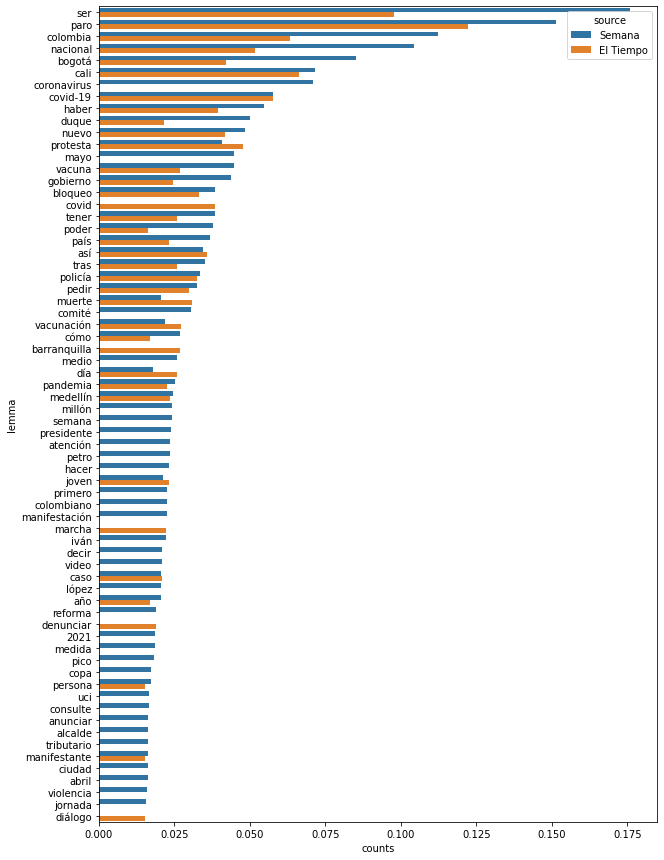

In [ ]:
semana_lemmas = [token for tokens in lm_semana_titles for token in tokens]
tks, cnts = np.unique(semana_lemmas, return_counts=True)
semana_counts = pd.DataFrame({'lemma': tks, 'counts':cnts/len(semana_titles)})
semana_counts['source'] = 'Semana'

eltiempo_lemmas = [token for tokens in lm_eltiempo_titles for token in tokens]
tks, cnts = np.unique(eltiempo_lemmas, return_counts=True)
eltiempo_counts = pd.DataFrame({'lemma': tks, 'counts':cnts/len(eltiempo_titles)})
eltiempo_counts['source'] = 'El Tiempo'

counts_df = pd.concat([semana_counts, eltiempo_counts]).sort_values(by='counts', ascending=False).head(100)

plt.figure(figsize=(10,15))
sns.barplot(data=counts_df, x='counts', y='lemma', hue='source')

The plot above shows that the usage of some words differ among newspapers. To be able to compare both, we scaled the counts by the number of availabe for each newspaper. We also do a word clouds with these lemmas:

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
semana_lemmas = [l for l in semana_lemmas if l !='ser']
eltiempo_lemmas = [l for l in eltiempo_lemmas if l!='ser']

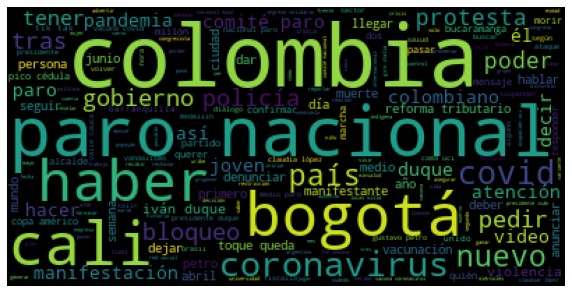

In [ ]:
txt = ' '.join(semana_lemmas)
wordcloud = WordCloud().generate(text=txt)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

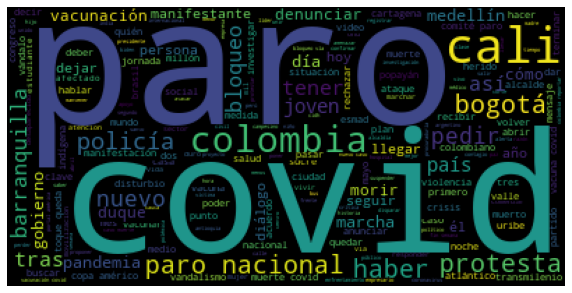

In [ ]:
txt = ' '.join(eltiempo_lemmas)
wordcloud = WordCloud().generate(text=txt)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Temporal

In [ ]:
def find_in_time(df_source, tokens, use_lemmas=False):
    df_found = df_source[['date', 'source', 'tokens']]\
    .apply(lambda x: pd.Series({
        'date':x['date'],
        'source': x['source'],
        'found': any([t in x['tokens' if not use_lemmas else 'lemmas'] for t in tokens])
    }), axis=1).groupby(by=['date', 'source']).sum()
    return df_found.reset_index()

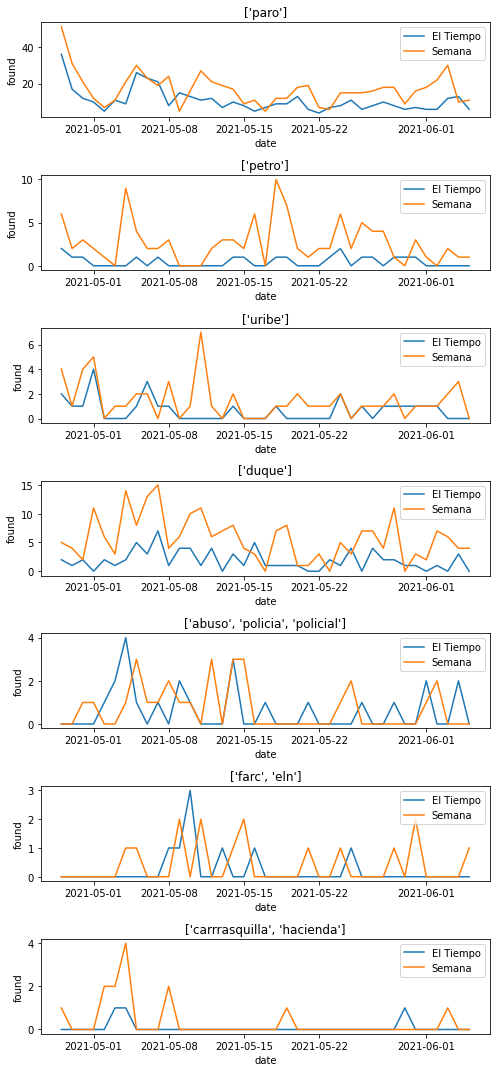

In [ ]:
terms = [['paro'], ['petro'], ['uribe'], ['duque'], ['abuso', 'policia', 'policial'], ['farc', 'eln'], ['carrrasquilla', 'hacienda']]

fig = plt.figure(figsize=(7, 15))
for i, term_set in enumerate(terms):
    word_counts = find_in_time(df_articles, term_set)
    plt.subplot(len(terms),1,i+1)
    sns.lineplot(data=word_counts, x='date', y='found', hue='source')
    plt.title(term_set)
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Tag grouping and association rules

Simple Model. We use w2v and KMeans.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
nlp = es_core_news_lg.load()

In [ ]:
semana_tags = [t for tags in df_articles[df_articles['source'] == 'Semana']['tags'].values for t in tags]
tags, cnt = np.unique(semana_tags, return_counts=True)

In [ ]:
vectors = []
for tag in tqdm(tags):
    tokens = nlp(str(tag))
    vect = np.sum([token.vector for token in tokens], axis=0)
    vectors.append(vect)

100%|██████████| 2329/2329 [00:16<00:00, 140.09it/s]


In [ ]:
n_clusters = np.arange(2, 50, 2)
inertia = []
for n in tqdm(n_clusters):
    model = KMeans(n_clusters=n)
    model.fit(vectors)
    inertia.append(model.inertia_)

100%|██████████| 24/24 [00:42<00:00,  1.77s/it]


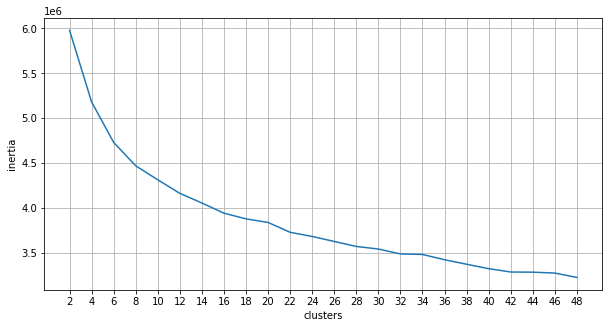

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(n_clusters, inertia)
plt.xticks(n_clusters)
plt.xlabel('clusters')
plt.ylabel('inertia')
plt.grid()
plt.show()

In [ ]:
model = KMeans(n_clusters=10)
model.fit(vectors)
labels = model.predict(vectors)

In [ ]:
tags = np.array(tags)

In [ ]:
tags[labels == 0][:20]

array(['Alejandro Riaño en su papel de Juanpis González',
       'Avianca en ley de quiebras', 'Aviones de combate en Colombia',
       'Belén de Bajirá es de Antioquia o Chocó',
       'Caimanes en peligro de extinción',
       'Casos de coronavirus en Argentina',
       'Casos de coronavirus en Colombia',
       'Casos de coronavirus en el mundo', 'Cortes de agua en Bogotá',
       'Cortes de luz en Bogotá', 'Cámara de Comercio de Bogotá',
       'Cáncer de mama en Colombia',
       'Delimitación del Páramo de Santurbán',
       'Departamento de Estado de Estados Unidos',
       'Empresa de Acueducto y Alcantarillado de Bogotá',
       'Escasez de combustible en Pasto',
       'Fernando Gaviria en Giro de Italia', 'Grupo de Energía de Bogotá',
       'Mejores universidades de Colombia en 2020',
       'Ministerio de Relaciones Exteriores de Colombia'], dtype='<U56')

In [ ]:
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=10)
T = tsne.fit_transform(vectors)

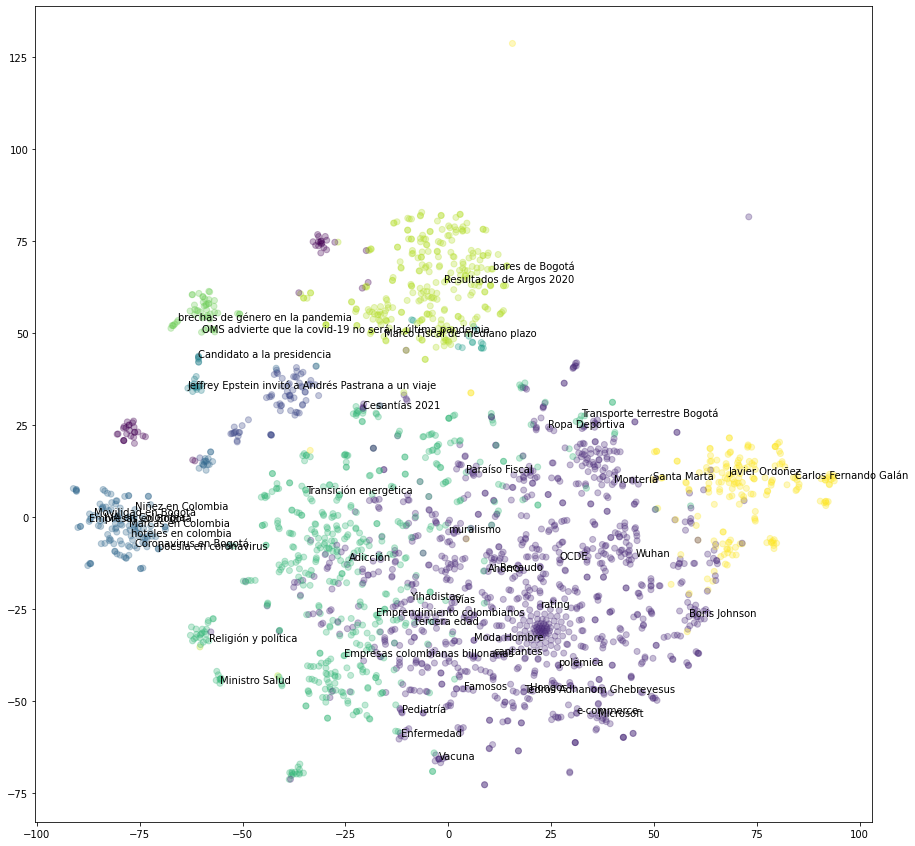

In [ ]:
plt.figure(figsize=(15,15))
n_docs=50
idx = np.arange(len(tags))
valid_idx = np.random.choice(idx, replace=False, size=n_docs)
plt.scatter(T[:, 0], T[:, 1], alpha=0.3, c=labels)
plot_titles=[tags[i] for i in valid_idx]
for label, x, y in zip(plot_titles, T[valid_idx, 0], T[valid_idx, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

This is interesting, because it grouped together some stuff such as people names, business names, places, etc., yet it can be improved. Furthermore, there are some tags that are quite similar (i.e. 'policia' and 'policia nacional'), and it would be a good idea to group them.

Nevertheless we will use our tags as is, and try to find association rules among them.

In [ ]:
!pip install -q pyfpgrowth efficient_apriori
from efficient_apriori import apriori
import pyfpgrowth

     |████████████████████████████████| 1.6 MB 2.3 MB/s 


In [ ]:
semana_tags = [t for tags in df_articles[df_articles['source'] == 'Semana']['tags'].values for t in tags]
tags, cnt = np.unique(semana_tags, return_counts=True)
print("UNIQUE TAGS:",len(tags))

UNIQUE TAGS: 2329


In [ ]:
all_tags = [t.lower() for tags in df_articles['tags'].values for t in tags]
tags, cnt = np.unique(all_tags, return_counts=True)
print("UNIQUE TAGS",len(tags))
print("ALL TAGS", len(all_tags))

UNIQUE TAGS 4062
ALL TAGS 26910


In [ ]:
all_tags = [[t.lower() for t in tags]for tags in df_articles['tags'].values]

In [ ]:
itemsets, rules = apriori(all_tags, min_support=0.001, min_confidence=0.01)

In [ ]:
for r in rules:
    if r.confidence > 0.2:
        print(r)

{perú} -> {keiko fujimori} (conf: 0.364, supp: 0.001, lift: 360.273, conv: 1.570)
{keiko fujimori} -> {perú} (conf: 1.000, supp: 0.001, lift: 360.273, conv: 997224325.006)
{ministerio de defensa} -> {cali} (conf: 0.212, supp: 0.001, lift: 3.021, conv: 1.179)
{policía} -> {cali} (conf: 0.231, supp: 0.007, lift: 3.305, conv: 1.210)
{ministerio de defensa} -> {policía} (conf: 0.327, supp: 0.002, lift: 10.707, conv: 1.440)
{cali} -> {paro nacional} (conf: 0.364, supp: 0.025, lift: 1.668, conv: 1.229)
{protestas} -> {paro nacional} (conf: 0.378, supp: 0.014, lift: 1.730, conv: 1.256)
{paro nacional 28 de abril} -> {paro nacional} (conf: 0.328, supp: 0.008, lift: 1.504, conv: 1.164)
{violencia} -> {paro nacional} (conf: 0.255, supp: 0.003, lift: 1.167, conv: 1.049)
{policía} -> {paro nacional} (conf: 0.331, supp: 0.010, lift: 1.515, conv: 1.168)
{alvaro uribe} -> {paro nacional} (conf: 0.260, supp: 0.002, lift: 1.191, conv: 1.056)
{elecciones 2022} -> {gustavo petro} (conf: 0.526, supp: 0.00

In [ ]:
patterns = pyfpgrowth.find_frequent_patterns(all_tags, support_threshold=0.01)
rules = pyfpgrowth.generate_association_rules(patterns, 0.01)

In [ ]:
for k, v in rules.items():
    if v[1] < 0.2:
        print(k, "->", v[0], " - ", v[1])

('economía', 'pandemia') -> ('paro nacional',)  -  0.125
('economía', 'paro nacional') -> ('pandemia',)  -  0.16666666666666666
('pandemia', 'paro nacional') -> ('coronavirus',)  -  0.16666666666666666
('fiscalía general de la nación', 'paro nacional') -> ('cali',)  -  0.125
('eliminatorias catar 2022', 'selección colombia') -> ('copa américa',)  -  0.14285714285714285
('noticias hoy colombia', 'paro nacional') -> ('coronavirus',)  -  0.013888888888888888
('bloqueos de carretera', 'paro nacional') -> ('paro',)  -  0.04918032786885246
('paro nacional hoy', 'semana podcast') -> ('paro nacional',)  -  0.16666666666666666
('empresas', 'paro nacional') -> ('bloqueos de carretera',)  -  0.16666666666666666
('paro nacional', 'vandalismo') -> ('cali',)  -  0.1206896551724138
('bloqueos de carretera', 'comité del paro nacional') -> ('marchas', 'paro')  -  0.125
('comité del paro nacional', 'paro nacional') -> ('paro',)  -  0.04
('bucaramanga', 'paro nacional') -> ('protestas',)  -  0.0714285714

### Word clouds

#Topic analysis

In [ ]:
%pip install pyLDAvis
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA
from pyLDAvis import sklearn as sklearn_lda
import pickle, pyLDAvis, os

     |████████████████████████████████| 1.7 MB 3.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.3 MB 216 kB/s 
     |████████████████████████████████| 9.9 MB 46.9 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=e70b1b5c642a3780ce70b6a97dd09be83247a35049483354335579a1305b484c
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



## Semana

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared')

In [ ]:
df_articles['extra_txt'] = df_articles['extra_txt'].replace(np.nan, '')

In [ ]:
def join_texts(series):
    title = series['title'].strip()
    txt = series['extra_txt'].strip() if series['extra_txt'] else ''

    if title[-1] != '.': title +='.'
    full_txt = title + ' ' + txt
    return pd.Series({
        'full_txt': full_txt
    })

df_articles['full_txt'] = df_articles.apply(join_texts,axis=1)

In [ ]:
semana_corpus = [preprocessing_tok(txt) for txt in df_articles[df_articles['source'] == 'Semana']['full_txt'].values]
eltiempo_corpus = [preprocessing_tok(txt) for txt in df_articles[df_articles['source'] == 'El Tiempo']['full_txt'].values]

Using tfidf and LSA

In [ ]:
tfidf = TfidfVectorizer(stop_words=list(stop_words_sp), max_features=None, max_df=0.5, sublinear_tf=True)
tfidf.fit(semana_corpus)
tfidf_semana = tfidf.transform(semana_corpus).toarray()

In [ ]:
bow=CountVectorizer(stop_words=list(stop_words_sp), max_features=None, max_df=0.5)
bow.fit(semana_corpus)
bow_semana=bow.transform(semana_corpus).toarray()

In [ ]:
model = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=100, random_state=1234)
model.fit(bow_semana)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=100,
             random_state=1234, tol=0.0)

In [ ]:
def show_top(model, terms):
    for i, comp in enumerate(model.components_):
        terms_comp=zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
        print("Tópico {}: {}".format(i," ".join(list(map(lambda x:x[0], sorted_terms)))))

show_top(model, tfidf.get_feature_names())

Tópico 0: paro nacional colombia país gobierno bogotá duque comité cali medio
Tópico 1: colombia covid coronavirus país bogotá casos salud pandemia vacunas millones
Tópico 2: bogotá cali mayo ciudad uci camas capital covid nacional ocupación
Tópico 3: duque cali presidente iván ciudad reforma tributaria tras valle bogotá
Tópico 4: colombia bogotá cali protestas policía mayo manifestaciones semana violencia manifestantes


Using BOW and LDA

In [ ]:
model = LDA(n_components=5, n_jobs=-1)
model.fit(bow_semana)

show_top(model, bow.get_feature_names())

Tópico 0: colombia país paro américa copa nacional pandemia gobierno millones semana
Tópico 1: cali paro nacional protestas policía personas colombia bogotá violencia medio
Tópico 2: cali policía gobierno paro público colombia fuerza nacional medio pública
Tópico 3: covid coronavirus colombia país salud casos pandemia vacunas vacunación dosis
Tópico 4: paro nacional duque colombia bogotá país presidente mayo gobierno comité


In [ ]:
LDAvis_prepared=sklearn_lda.prepare(model, np.matrix(bow_semana), bow)
pyLDAvis.save_html(LDAvis_prepared, './lda_bow.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.113472  0.146746       1        1  27.030727
1     -0.086866 -0.089229       2        1  20.721221
3      0.204186  0.029976       3        1  18.671200
2     -0.044670 -0.074293       4        1  17.640448
0      0.040822 -0.013200       5        1  15.936405, topic_info=              Term        Freq       Total Category  logprob  loglift
3167   coronavirus  412.000000  412.000000  Default  30.0000  30.0000
3225         covid  427.000000  427.000000  Default  29.0000  29.0000
4485         duque  325.000000  325.000000  Default  28.0000  28.0000
9238          paro  946.000000  946.000000  Default  27.0000  27.0000
2618        comité  213.000000  213.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
8136         medio   35.210261  275.207369   Topic5  -5.9627  -0.2196
3167   coronavirus   37.730447  412.226284   Topic5  -5.8935  -0.5545
11822       social   25.928476   90.674117   Topic5  -6.2686   0.5846
12572         tras   28.899392  234.933579   Topic5  -6.1602  -0.2589
1716      bloqueos   28.474207  244.792428   Topic5  -6.1750  -0.3148

[371 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
18         1  0.975647  abastecimiento
59         1  0.643411           abril
59         2  0.063634           abril
59         3  0.106057           abril
59         4  0.134339           abril
...      ...       ...             ...
13242      1  0.827779            vías
13242      4  0.115260            vías
13242      5  0.052391            vías
13274      4  0.908115          wilson
13333      2  0.965886          álvaro

[671 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])

## El Tiempo

Using tfidf and LSA

In [ ]:
tfidf = TfidfVectorizer(stop_words=list(stop_words_sp), max_features=None, max_df=0.5, sublinear_tf=True)
tfidf.fit(eltiempo_corpus)
tfidf_eltiempo = tfidf.transform(eltiempo_corpus).toarray()

In [ ]:
bow=CountVectorizer(stop_words=list(stop_words_sp), max_features=None, max_df=0.5)
bow.fit(eltiempo_corpus)
bow_eltiempo=bow.transform(eltiempo_corpus).toarray()

In [ ]:
model = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=100, random_state=1234)
model.fit(bow_eltiempo)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=100,
             random_state=1234, tol=0.0)

In [ ]:
def show_top(model, terms):
    for i, comp in enumerate(model.components_):
        terms_comp=zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
        print("Tópico {}: {}".format(i," ".join(list(map(lambda x:x[0], sorted_terms)))))

show_top(model, tfidf.get_feature_names())

Tópico 0: paro nacional cali gobierno covid protestas colombia bogotá país comité
Tópico 1: covid colombia casos muertes salud nuevos país vacunación barranquilla contagios
Tópico 2: cali policía protestas tras ciudad manifestantes valle bloqueos bogotá alcalde
Tópico 3: colombia país copa gobierno américa situación protestas tras muertes duque
Tópico 4: cali casos muertes paro nuevos colombia salud reportó ministerio nacional


Using BOW and LDA

In [ ]:
model = LDA(n_components=5, n_jobs=-1)
model.fit(bow_eltiempo)

show_top(model, bow.get_feature_names())

Tópico 0: paro cali tras covid presidente pandemia protestas mayo nacional colombia
Tópico 1: covid salud casos muertes colombia paro vacunación uci país nuevos
Tópico 2: paro cali policía tras bloqueos gobierno protestas nacional dos manifestantes
Tópico 3: paro cali nacional protestas queda toque colombia violencia medellín gobierno
Tópico 4: covid paro bogotá colombia nacional país copa así cali américa


In [ ]:
LDAvis_prepared=sklearn_lda.prepare(model, np.matrix(bow_eltiempo), bow)
pyLDAvis.save_html(LDAvis_prepared, './lda_bow.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.065442 -0.029627       1        1  24.720771
4      0.012939  0.130574       2        1  21.268893
1     -0.158095 -0.024255       3        1  20.097278
0      0.029852 -0.011928       4        1  17.424834
3      0.049862 -0.064764       5        1  16.488224, topic_info=         Term        Freq       Total Category  logprob  loglift
2433    covid  358.000000  358.000000  Default  30.0000  30.0000
1620    casos   91.000000   91.000000  Default  29.0000  29.0000
6368  muertes   87.000000   87.000000  Default  28.0000  28.0000
8608    salud  116.000000  116.000000  Default  27.0000  27.0000
9535      uci   63.000000   63.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
873       así   22.140702  150.224525   Topic5  -5.8200  -0.1122
7032     país   22.449373  203.752872   Topic5  -5.8062  -0.4031
3379      día   17.126832   84.751453   Topic5  -6.0768   0.2034
369   alcalde   15.613268   58.791357   Topic5  -6.1693   0.4766
2433    covid   17.271116  358.855836   Topic5  -6.0684  -1.2314

[375 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
31        4  0.747197     aborto
62        1  0.799254      abuso
62        2  0.039963      abuso
62        5  0.159851      abuso
152       3  0.888071    activos
...     ...       ...        ...
9867      5  0.419216  violencia
9869      4  0.139304   violenta
9869      5  0.696520   violenta
9908      4  0.156689      visto
9908      5  0.783445      visto

[693 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 1, 4])

#Grouping

### Alternative embeddings

In [ ]:
# https://github.com/dccuchile/spanish-word-embeddings
!pip install -q gensim
!wget cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2
!wget dcc.uchile.cl/~jperez/word-embeddings/fasttext-sbwc.vec.gz
!bzip2 -dk SBW-vectors-300-min5.txt.bz2
!gzip -d fasttext-sbwc.vec.gz

--2021-06-07 07:16:08--  http://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2
Resolving cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)... 200.16.17.55
Connecting to cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)|200.16.17.55|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2 [following]
--2021-06-07 07:16:08--  https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2
Connecting to cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)|200.16.17.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 818175453 (780M) [application/x-bzip2]
Saving to: ‘SBW-vectors-300-min5.txt.bz2’

SBW-vectors-300-min 100%[===================>] 780.27M  17.6MB/s    in 44s     

2021-06-07 07:16:53 (17.6 MB/s) - ‘SBW-vectors-300-min5.txt.bz2’ saved [818175453/818175453]



In [ ]:
from gensim.models import KeyedVectors
#vectors = KeyedVectors.load_word2vec_format('SBW-vectors-300-min5.txt', binary=False)
vectors = KeyedVectors.load_word2vec_format('fasttext-sbwc.vec', binary=False)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:418: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information



In [ ]:
semana_corpus = df_articles[df_articles['source'] == 'Semana']['full_txt'].values
semana_titles = df_articles[df_articles['source'] == 'Semana']['title'].values
eltiempo_corpus = df_articles[df_articles['source'] == 'El Tiempo']['full_txt'].values
eltiempo_titles = df_articles[df_articles['source'] == 'El Tiempo']['title'].values

In [ ]:
def w2v_avg(doc):
    return np.sum([vectors[w] for w in doc if w in vectors.vocab], axis = 0)
semana_vectors = list(map(w2v_avg, list(map(tokenize, semana_corpus))))

### KMeans

In [ ]:
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans

In [ ]:
semana_corpus = df_articles[df_articles['source'] == 'Semana']['full_txt'].values
semana_titles = df_articles[df_articles['source'] == 'Semana']['title'].values
eltiempo_corpus = df_articles[df_articles['source'] == 'El Tiempo']['full_txt'].values
eltiempo_titles = df_articles[df_articles['source'] == 'El Tiempo']['title'].values

In [ ]:
semana_vectors = []
for title in tqdm(semana_corpus):
    tokens = nlp(title)
    vect = np.sum([token.vector for token in tokens], axis=0)
    semana_vectors.append(vect)

100%|██████████| 4461/4461 [01:00<00:00, 73.22it/s]


In [ ]:
inertia = []
n_clusters = [1,2,3,5,8,10,15,20,30,40,50]
for n in tqdm(n_clusters):
    clf = KMeans(n_clusters=n)
    clf.fit(semana_vectors)
    clusters = clf.predict(semana_vectors)
    inertia.append(clf.inertia_)

100%|██████████| 11/11 [00:38<00:00,  3.55s/it]


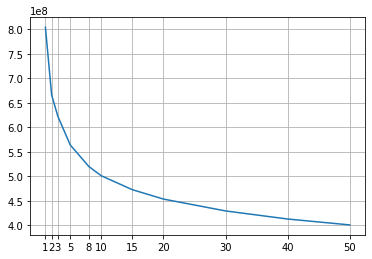

In [ ]:
plt.plot(n_clusters, inertia)
plt.xticks(n_clusters)
plt.grid()

In [ ]:
tsne = TSNE(n_components=2, n_iter=1000)
T = tsne.fit_transform(semana_vectors)

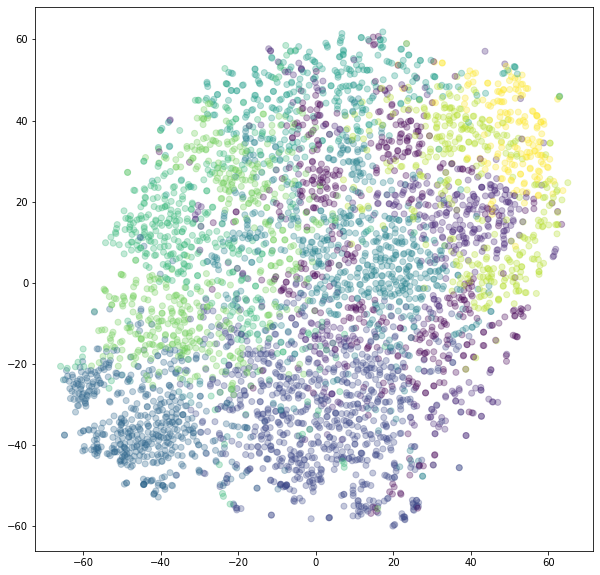

In [ ]:
clf = KMeans(n_clusters=10)
clf.fit(semana_vectors)
clusters = clf.predict(semana_vectors)
plt.figure(figsize=(10, 10))
plt.scatter(T[:, 0], T[:, 1], c=clusters, alpha=0.3)

In [ ]:
def sample_titles(titles, clusters, points, n_elements = 5):
    cluster_ids = np.unique(clusters)
    sample = []
    for id in cluster_ids:
        filtered = titles[clusters == id]

        idx = np.arange(len(filtered))
        valid_idx = np.random.choice(idx, replace=False, size=n_elements)
        plot_titles = [titles[i] for i in valid_idx]
        point_choice = points[valid_idx]
        sample.append([plot_titles, point_choice])
    
    return sample

In [ ]:
sample = sample_titles(semana_titles, clusters, T)
for i, e in enumerate(sample):
    print("CLUSTER {}".format(i))
    for t in e[0]:
        print(">", t)

CLUSTER 0
> Estas son las buenas noticias económicas que tuvo Colombia este lunes
> “No hay excusa para no asegurar la presencialidad a partir del 15 de julio en escuelas y colegios”: MinSalud
> En carta abierta, Pablo Montoya renuncia a eventos culturales organizados por el Gobierno
> “Estamos listos para iniciar la negociación”: Gobierno envió mensaje directo al Comité de Paro
> Las nuevas rutas de las aerolíneas para estas vacaciones
CLUSTER 1
> ¿Acatará la Policía el fallo que ordena entregar nombres de los comandantes del Esmad antes de realizar un procedimiento?
> Empresarios, la verdadera resistencia
> Las nuevas rutas de las aerolíneas para estas vacaciones
> Todas las obras de construcción adelantadas por el IDU se han visto afectadas por las manifestaciones
> “Queremos que la CIDH escuche a todos los afectados, también los casos de dos bebés que murieron por bloqueos”: Marta Lucía Ramírez
CLUSTER 2
> Iván Duque: “Nunca dialogaremos con vías de hecho, eso es chantaje o extorsi

### GMM

In [ ]:
from sklearn.mixture import GaussianMixture as GMM

In [ ]:
gmm_model = GMM(n_components=10)
gmm_model.fit(semana_vectors)
clusters = gmm_model.predict(semana_vectors)

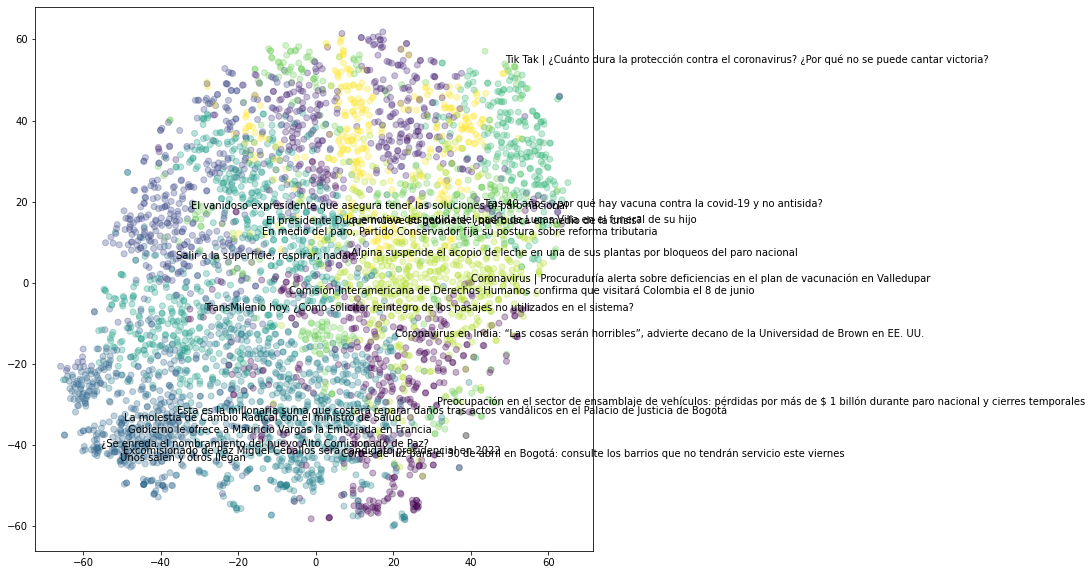

In [ ]:
plt.figure(figsize=(10,10))
n_docs=20
idx = np.arange(len(semana_titles))
valid_idx = np.random.choice(idx, replace=False, size=n_docs)
plt.scatter(T[:, 0], T[:, 1], c=clusters, alpha=0.3)
plot_titles=[semana_titles[i] for i in valid_idx]
for label, x, y in zip(plot_titles, T[valid_idx, 0], T[valid_idx, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

In [ ]:
sample = sample_titles(semana_titles, clusters, T)
for i, e in enumerate(sample):
    print("CLUSTER {}".format(i))
    for t in e[0]:
        print(">", t)

CLUSTER 0
> “Que nos muestren sus declaraciones de renta”: la solicitud de Mario Hernández al Comité del Paro
> Las seis exigencias controvertidas del Comité Nacional del Paro
> Deportivo Cali vs. Tolima: Dimayor definió estadio, fecha y hora del partido
> Paro nacional | ¿Cuánto le han costado las marchas a la economía colombiana?
> Alcalde de Cali adelantará mesa de diálogo con integrantes de la Primera Línea para avanzar en los desbloqueos
CLUSTER 1
> Paro nacional: dueño del Porsche que atropelló a joven en Bogotá habla en SEMANA
> “Solo se arrodillan ante el dinero”: Matador se va contra los jugadores de la Selección Colombia
> ¿Bogotá y Medellín tendrán toque de queda hoy martes?
> Perú se la juega en las elecciones presidenciales: ¿Keiko Fujimori o Pedro Castillo?
> Imbatible: así fue el rating del partido Perú vs. Colombia por las eliminatorias
CLUSTER 2
> Dólar | En las casas de cambio está más caro que el dólar oficial. ¿Por qué?
> Atención | Moción de censura contra el minis